# Chapter: Dimension Reduction and Latent Variable Methods (Part 1)


# Topic: Process Monitoring using PCA

In [20]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          train PCA model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
# import required packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [10]:
# fetch data
data = pd.read_excel('proc1a.xls', skiprows = 1,usecols = 'C:AI')

# separate train data
data_train = data.iloc[0:69,]
           
# scale data
scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_train)
           
# PCA
pca = PCA()
score_train = pca.fit_transform(data_train_normal)

# decide # of PCs to retain and compute reduced data in PC space
explained_variance = 100*pca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained

n_comp = np.argmax(cum_explained_variance >= 90) + 1
score_train_reduced = score_train[:,0:n_comp]

print('Number of PCs cumulatively explaining atleast 90% variance: ', n_comp)

Number of PCs cumulatively explaining atleast 90% variance:  13


In [11]:
# reconstruct original data
V_matrix = pca.components_.T
P_matrix = V_matrix[:,0:n_comp] 

data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)

In [16]:
# calculate T2 for training data
lambda_k = np.diag(pca.explained_variance_[0:n_comp]) # eigenvalue = explained variance
lambda_k_inv = np.linalg.inv(lambda_k)

T2_train = np.zeros((data_train_normal.shape[0],))

for i in range(data_train_normal.shape[0]):
    T2_train[i] = np.dot(np.dot(score_train_reduced[i,:],lambda_k_inv),score_train_reduced[i,:].T)

# calculate Q for training data
error_train = data_train_normal - data_train_normal_reconstruct
Q_train = np.sum(error_train*error_train, axis = 1)

In [17]:
# T2_train control limit
import scipy.stats

N = data_train_normal.shape[0]
k = n_comp

alpha = 0.01# 99% control limit
T2_CL = k*(N**2-1)*scipy.stats.f.ppf(1-alpha,k,N-k)/(N*(N-k))

# Q_train control limit
eig_vals = pca.explained_variance_
m = data_train_normal.shape[1]

theta1 = np.sum(eig_vals[k:])
theta2 = np.sum([eig_vals[j]**2 for j in range(k,m)])
theta3 = np.sum([eig_vals[j]**3 for j in range(k,m)])
h0 = 1-2*theta1*theta3/(3*theta2**2)

z_alpha = scipy.stats.norm.ppf(1-alpha)
Q_CL = theta1*(z_alpha*np.sqrt(2*theta2*h0**2)/theta1+ 1 + theta2*h0*(1-h0)/theta1**2)**2 

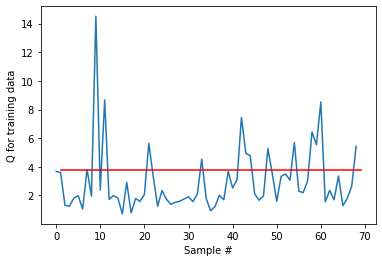

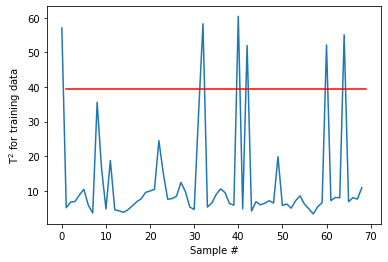

In [18]:
#%% Q_train plot with CL
plt.figure()
plt.plot(Q_train)
plt.plot([1,len(Q_train)],[Q_CL,Q_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('Q for training data')
plt.show()

#%% T2_train plot with CL
plt.figure()
plt.plot(T2_train)
plt.plot([1,len(T2_train)],[T2_CL,T2_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('T$^2$ for training data')
plt.show()

In [21]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [22]:
# get test data, normalize it
data_test = data.iloc[69:,]
data_test_normal = scaler.transform(data_test) # using scaling parameters from training data

# compute scores and reconstruct
score_test = pca.transform(data_test_normal)
score_test_reduced = score_test[:,0:n_comp]

data_test_normal_reconstruct = np.dot(score_test_reduced, P_matrix.T)

In [23]:
# calculate T2_test
T2_test = np.zeros((data_test_normal.shape[0],))

for i in range(data_test_normal.shape[0]): # eigenvalues from training data are used
    T2_test[i] = np.dot(np.dot(score_test_reduced[i,:],lambda_k_inv),score_test_reduced[i,:].T)

# calculate Q_test
error_test = data_test_normal_reconstruct - data_test_normal
Q_test = np.sum(error_test*error_test, axis = 1)

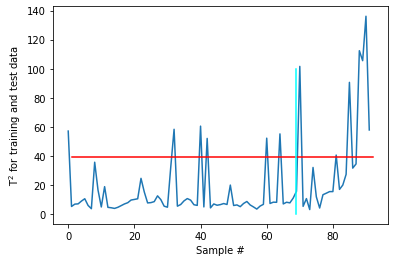

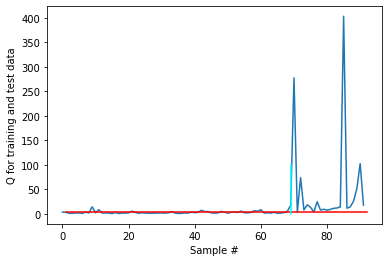

In [24]:
# plot T2_test and T2_train with CL
T2_combined = np.concatenate([T2_train,T2_test])

plt.figure()
plt.plot(T2_combined)
plt.plot([1,len(T2_combined)],[T2_CL,T2_CL], color='red')
plt.plot([69,69],[0,100], color='cyan')
plt.xlabel('Sample #')
plt.ylabel('T$^2$ for training and test data')
plt.show()

# plot Q_test and Q_train with CL
Q_combined = np.concatenate([Q_train,Q_test])

plt.figure()
plt.plot(Q_combined)
plt.plot([1,len(Q_combined)],[Q_CL,Q_CL], color='red')
plt.plot([69,69],[0,100], color='cyan')
plt.xlabel('Sample #')
plt.ylabel('Q for training and test data')
plt.show()

In [25]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          fault diagnosis by contribution plots
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


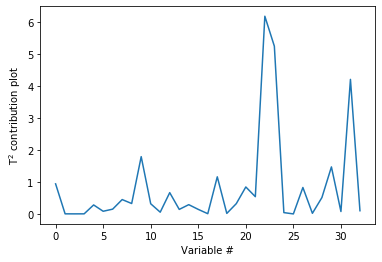

In [26]:
# T2 contribution
sample = 85 - 69
data_point = np.transpose(data_test_normal[sample-1,])

D = np.dot(np.dot(P_matrix,lambda_k_inv),P_matrix.T)
T2_contri = np.dot(scipy.linalg.sqrtm(D),data_point)**2 # vector of contributions

plt.figure()
plt.plot(T2_contri)
plt.xlabel('Variable #')
plt.ylabel('T$^2$ contribution plot')
plt.show()

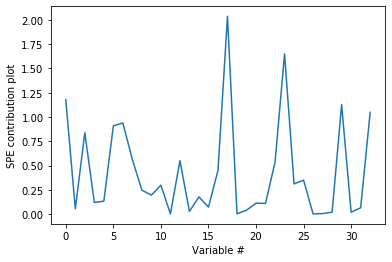

In [27]:
# SPE contribution
error_test_sample = error_test[sample-1,]
SPE_contri = error_test_sample*error_test_sample # vector of contributions

plt.figure()
plt.plot(SPE_contri)
plt.xlabel('Variable #')
plt.ylabel('SPE contribution plot')
plt.show()

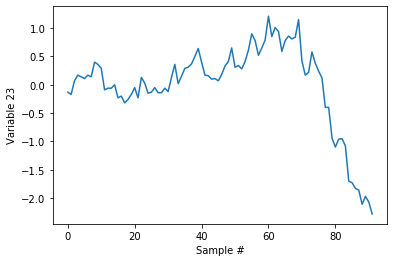

In [28]:
# variable plot
plt.figure()
plt.plot(data.iloc[:,23])
plt.xlabel('Sample #')
plt.ylabel('Variable 23')
plt.show()